# Polynomial Regression with Flux/Zygote

Chapter 1 of any machine learning book always has a short paragraph on linear regression.

Toolkits of the like of TensorFlow or Flux are useful in their ability to perform complex derivatives and orchestrate training algorithms on complex nonlinear and deep models. However, the focus nowadays is on optimizing the hottest neural network with minibatched stochastic gradient descent, which is usually only one chapter of an ML textbook. There are plently more classes of models that this programming approach can help us perform and develop. It's important that any automatic ML/Deep Learning package be able to derive these simple models. We can take the hard work out of deriving and implementing newer non-neural network models too.

A linear model is fit by:
\begin{equation}
f(x) = W basis(x) + b
\end{equation}
where "basis" is the The set $basis(x)=\{x\}$ is a linear model. We'll be doing polynomials where $basis(p)(x)=\{x,x^2,...x^p\}$.

We're going to take a different approach: instead of starting with the least-squares equation and deriving the matrix equation, we're going to define **the code for a function** and perform source code transformations on to get the **program** we need that performs the regression.

To get this to work, we have to use a bleeding edge branch of Zygote:
```juia
] add Zygote#mutate
```

In [1]:
using Flux, Zygote, Plots

In [2]:
include("./AfqsJuliaUtil.jl")
using .AfqsJuliaUtil

In [3]:
dat_x = collect(1:0.1:10);
dat_y = 0.1*dat_x.^2 .+ 5 .+ 0.5*rand(length(dat_x));
dat_x = reshape(dat_x,(1,length(dat_x)));
dat_y = reshape(dat_y,(1,length(dat_y)));

In [4]:
poly = AfqsJuliaUtil.@polynomial_function(1,3)
# W0 = rand(1,3);
# b0 = [2.0];
P0 = rand(4)
# P0 = mypars(W0,b0)
f(x,P) = P[1:3]'*poly(x).+P[4];
# pars=Flux.Tracker.Params([W,b])
loss(x,y, P) = Flux.mse(y,f(x,P))

loss (generic function with 1 method)

In [5]:
loss(dat_x,dat_y, P0)

133769.75609116151

In [6]:
P0

4-element Array{Float64,1}:
 0.03821126577366529
 0.07018472958199462
 0.9181273871851596 
 0.5535222853381947 

In [7]:
gradx_fwd(x) = Zygote.forward_jacobian( (P->loss(dat_x,dat_y, P)), x )[2];
hessx_fwd(x) = Zygote.forward_jacobian( gradx_fwd, x );

In [8]:
gradx(x) = Zygote.gradient( (P->loss(dat_x,dat_y, P)), x )[1]

gradx (generic function with 1 method)

In [9]:
gradx(P0)

4-element Array{Float64,1}:
   4071.9243180755307
  34188.660120610104 
 294891.8877231705   
    503.3787702081866

In [10]:
R,K=hessx_fwd(P0)

([4071.92; 34188.7; 2.94892e5; 503.379], [74.3 560.45 4506.19 11.0; 560.45 4506.19 37738.1 74.3; 4506.19 37738.1 3.25071e5 560.45; 11.0 74.3 560.45 2.0])

Note how the gradient (R) is the same as the backward differentiated case.

To do the least squares, we just solve the resulting system of equations:

In [11]:
ΔP = K\R;
P = P0 - ΔP

4×1 Array{Float64,2}:
 0.03399284265980596  
 0.0913569201692656   
 0.0004622040824610041
 5.253517563007837    

Notice how we recover `P[2]==0.1` and `P[4]==5`. We can verify that it looks right:

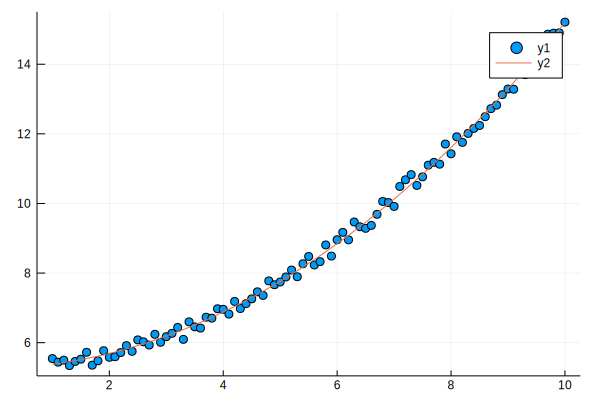

In [12]:
scatter(dat_x',dat_y')
plot!(dat_x',f(dat_x,P)')

## Why do we want to do this?


In [13]:
using StaticArrays

In [14]:
ps = SVector(P...)

4-element SArray{Tuple{4},Float64,1,4}:
 0.03399284265980596  
 0.0913569201692656   
 0.0004622040824610041
 5.253517563007837    

In [22]:
@inline @eval f_frz(x::Real) = f(x,$ps)

f_frz (generic function with 1 method)

In [24]:
@code_lowered f(1.0,ps)

CodeInfo(
1 ─ %1 = 1:3
│   %2 = (Base.getindex)(P, %1)
│   %3 = (Base.adjoint)(%2)
│   %4 = (Main.poly)(x)
│   %5 = %3 * %4
│   %6 = (Base.getindex)(P, 4)
│   %7 = (Base.broadcasted)(Main.:+, %5, %6)
│   %8 = (Base.materialize)(%7)
└──      return %8
)

In [17]:
pf=reshape(P,(:,))

4-element Array{Float64,1}:
 0.03399284265980596  
 0.0913569201692656   
 0.0004622040824610041
 5.253517563007837    

In [18]:
@code_lowered f(1.0, pf)

CodeInfo(
1 ─ %1 = 1:3
│   %2 = (Base.getindex)(P, %1)
│   %3 = (Base.adjoint)(%2)
│   %4 = (Main.poly)(x)
│   %5 = %3 * %4
│   %6 = (Base.getindex)(P, 4)
│   %7 = (Base.broadcasted)(Main.:+, %5, %6)
│   %8 = (Base.materialize)(%7)
└──      return %8
)

Ideally, we would want to backward differentiate the loss because it's more efficient when $N_{outputs} \ll N_{inputs}$. I'm note sure which algorithm would be better for the derivative of the gradient; probably forward differentiation. However, Zygote still has trouble forward differentiating something that was backward differentiated:

In [19]:
Zygote.hessian( (P->loss(dat_x,dat_y, P)), P0 )

MethodError: MethodError: no method matching (::Zygote.Jnew{ForwardDiff.Dual{Nothing,Float64,4},Nothing,false})(::ForwardDiff.Dual{Nothing,Float64,4})
Closest candidates are:
  Jnew(!Matched::Union{Nothing, RefValue, NamedTuple}) where {T, G} at /Users/afq/.julia/packages/Zygote/p7pxY/src/lib/lib.jl:218